Dataframe after mapping and combining themes:
   Country Name  Event    Language  Region  annotation_id no GG detected  \
0         Niger  COP26  translated  Africa            349            Yes   
1          Togo  COP28  translated  Africa            601            Yes   
2       Lesotho  COP24          en  Africa             35            Yes   
3     Mauritius  COP24          en  Africa             42            Yes   
4  Sierra Leone  COP24          en  Africa             53            Yes   

  region_specification         Theme_Combined  Year  Cumulative CO2  \
0                  NaN  Green-Growth Critical  2021        0.003010   
1                  NaN  Green-Growth Critical  2022        0.004017   
2                  NaN             Non-Growth  2018        0.003647   
3                  NaN             Non-Growth  2018        0.006598   
4                  NaN             Non-Growth  2018        0.002123   

     GDP_capita  Annual_Capita_CO2_Consumption    HDI HDI_Level  LDC S

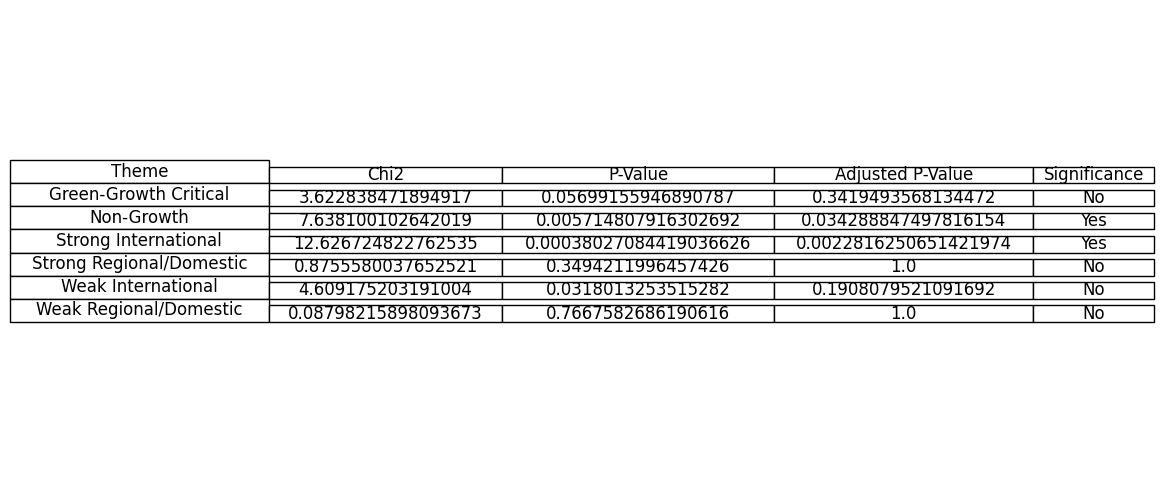

Total counts for each group:
SIDS_or_LDC
Non-SIDS or LDC    329
SIDS or LDC        190
dtype: int64
Percentages for each theme by group:
SIDS_or_LDC               Non-SIDS or LDC  SIDS or LDC
Theme_Combined                                        
Green-Growth Critical            6.382979    11.578947
Non-Growth                      40.729483    53.684211
Strong International            12.158055     2.631579
Strong Regional/Domestic        15.501520    12.105263
Weak International              13.373860     6.842105
Weak Regional/Domestic          11.854103    13.157895
Total percentages for each group:
SIDS_or_LDC
Non-SIDS or LDC    100.0
SIDS or LDC        100.0
dtype: float64


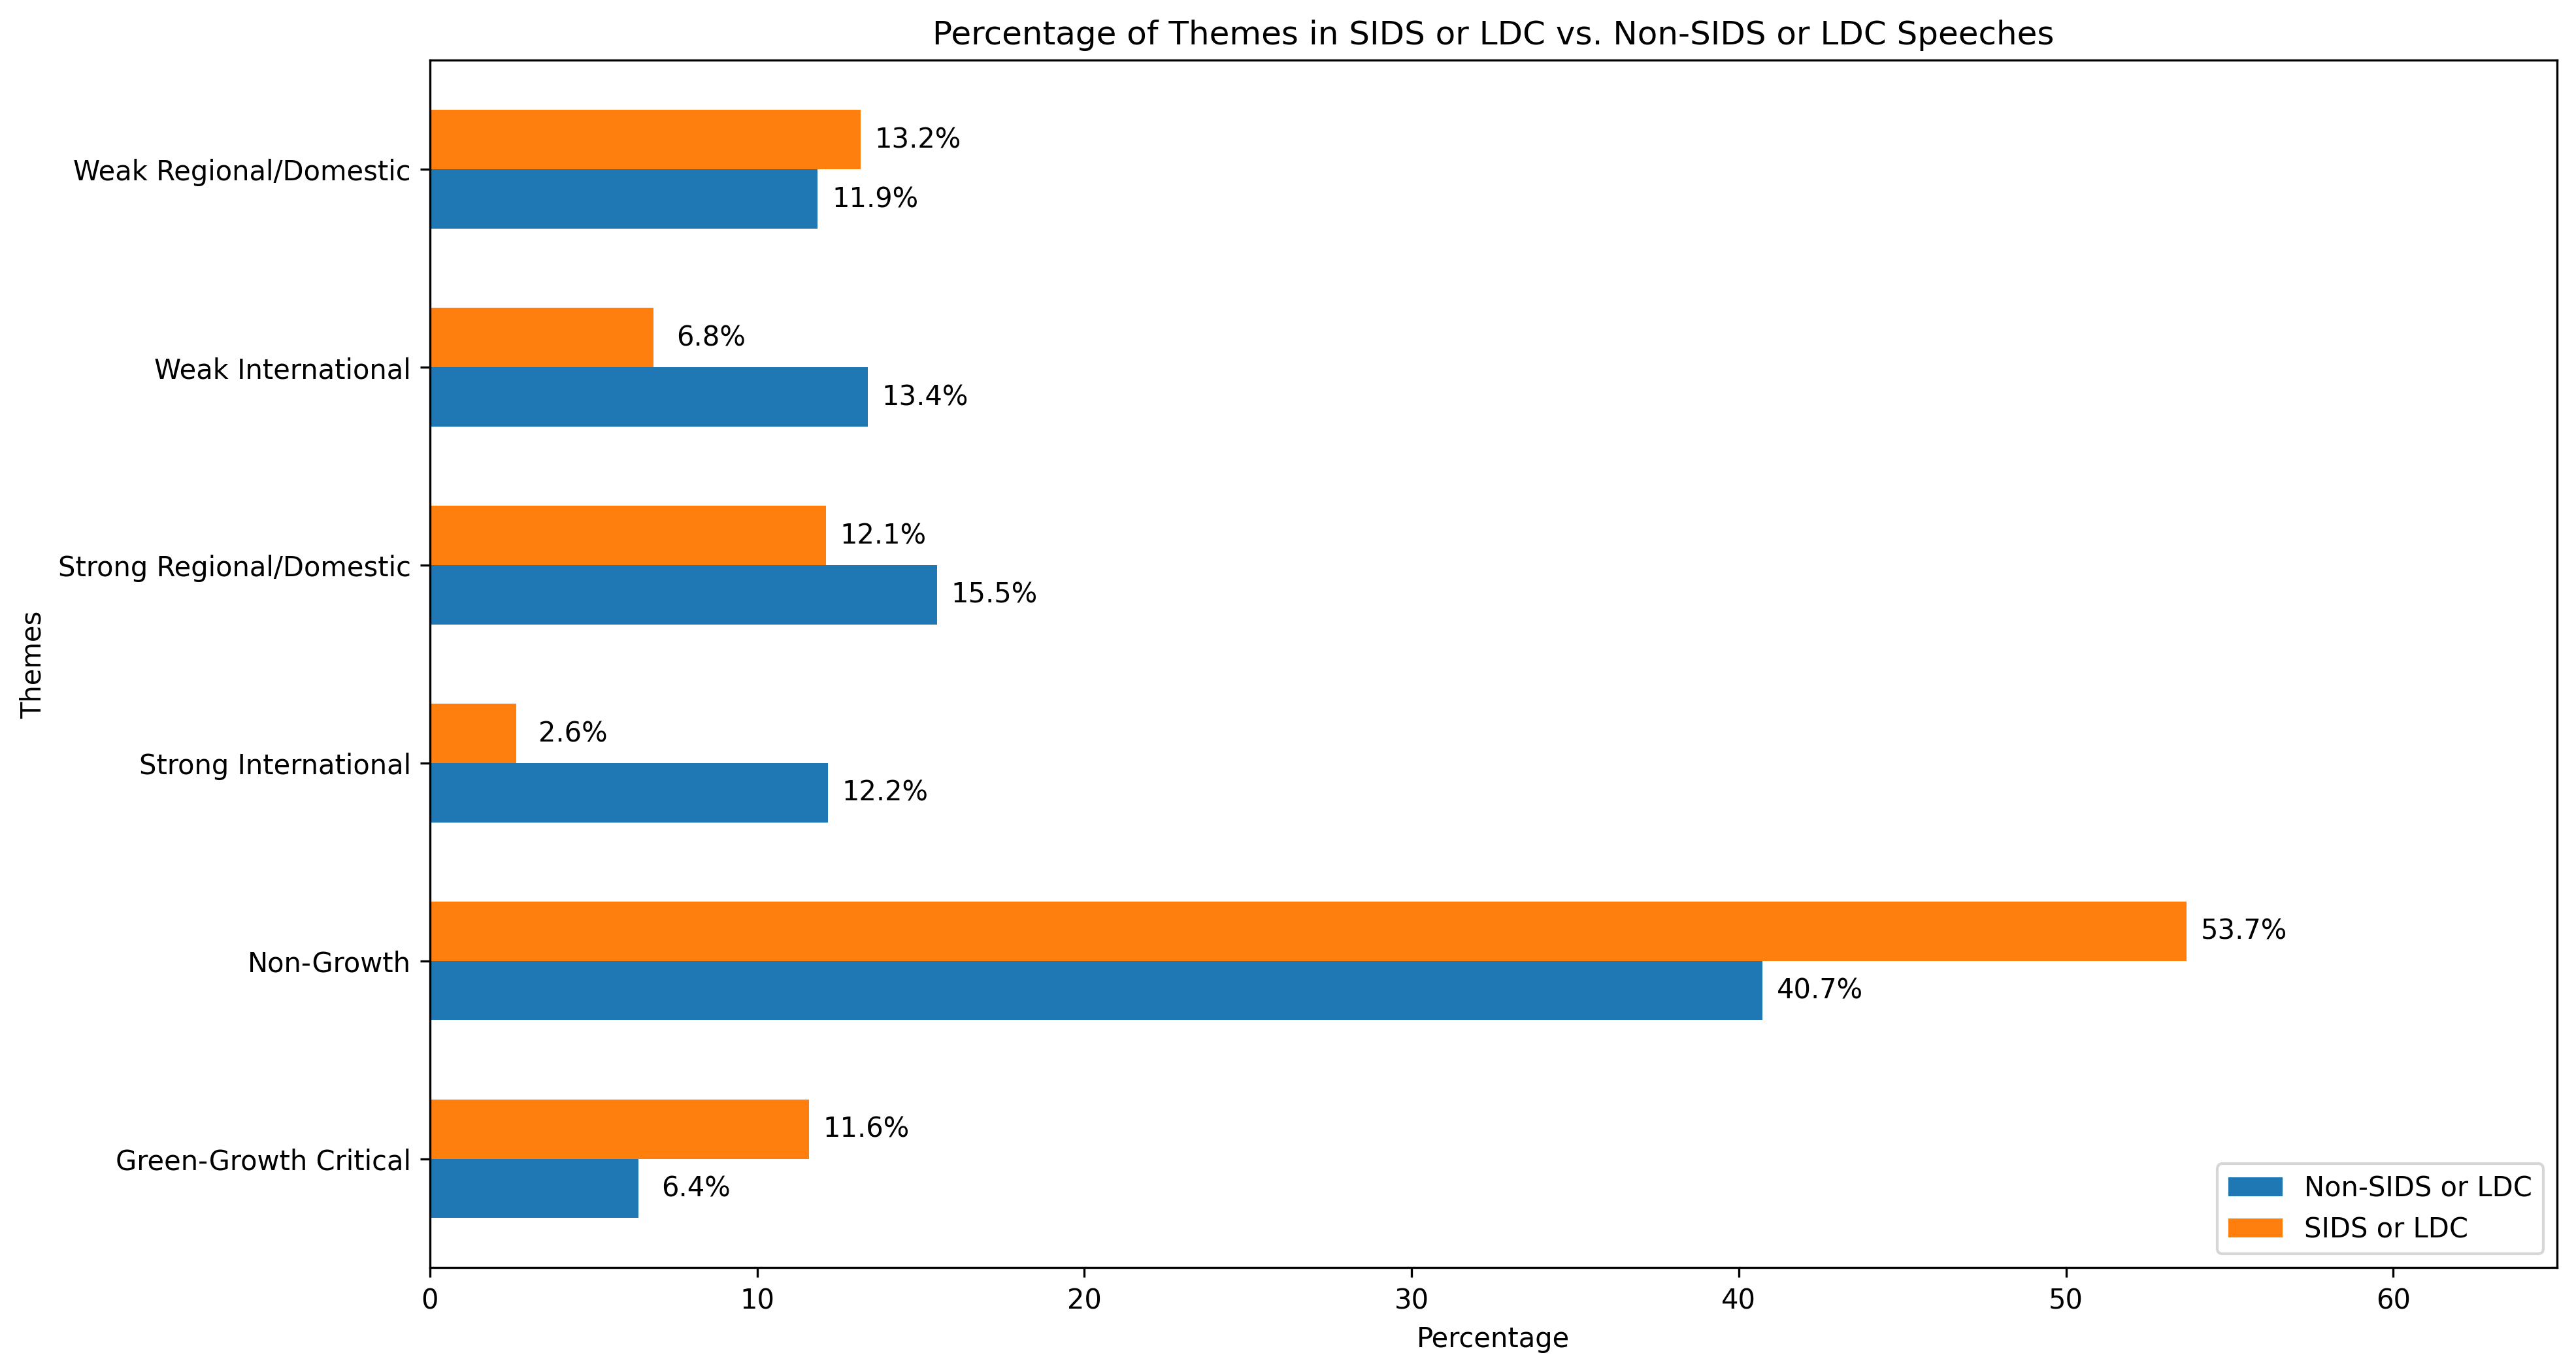

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('analysisdataset.csv')

# Create a new column 'SIDS_or_LDC' to combine SIDS and LDC
df['SIDS_or_LDC'] = df.apply(lambda row: 'SIDS or LDC' if row['SIDS'] == 'Yes' or row['LDC'] == 'Yes' else 'Non-SIDS or LDC', axis=1)

# Split the Theme_Combined column and create a long-format dataframe
df_themes = df.assign(Theme_Combined=df['Theme_Combined'].str.split()).explode('Theme_Combined')

# Ensure correct mapping of themes to their full names and combine specified themes
theme_mapping = {
    'S_int': 'Strong International',
    'S_reg': 'Strong Regional',
    'S_dom': 'Strong Domestic',
    'W_int': 'Weak International',
    'W_reg': 'Weak Regional',
    'W_dom': 'Weak Domestic',
    'AG': 'Green-Growth Critical',
    'NG': 'Non-Growth'
}

# Map themes
df_themes['Theme_Combined'] = df_themes['Theme_Combined'].map(theme_mapping)

# Combine Strong Regional and Strong Domestic into Strong Regional/Domestic
df_themes['Theme_Combined'] = df_themes['Theme_Combined'].replace({'Strong Regional': 'Strong Regional/Domestic',
                                                                    'Strong Domestic': 'Strong Regional/Domestic',
                                                                    'Weak Regional': 'Weak Regional/Domestic',
                                                                    'Weak Domestic': 'Weak Regional/Domestic'})

# Debug: Print the first few rows of the dataframe after mapping and combining themes
print("Dataframe after mapping and combining themes:")
print(df_themes.head())

# Group by theme and SIDS_or_LDC and count occurrences
grouped_data = df_themes.groupby(['SIDS_or_LDC', 'Theme_Combined']).size().reset_index(name='Count')

# Pivot the data to create a table of counts
pivot_table = grouped_data.pivot(index='Theme_Combined', columns='SIDS_or_LDC', values='Count').fillna(0)

# Perform chi-square tests
chi2_results = []
themes = pivot_table.index

for theme in themes:
    count_sids_ldc = pivot_table.loc[theme, 'SIDS or LDC']
    count_non_sids_ldc = pivot_table.loc[theme, 'Non-SIDS or LDC']
    
    # Create contingency table
    contingency_table = np.array([[count_sids_ldc, pivot_table['SIDS or LDC'].sum() - count_sids_ldc],
                                  [count_non_sids_ldc, pivot_table['Non-SIDS or LDC'].sum() - count_non_sids_ldc]])
    
    # Perform chi-square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append([theme, chi2, p])

# Create a DataFrame for results
results_df = pd.DataFrame(chi2_results, columns=['Theme', 'Chi2', 'P-Value'])

# Adjust p-values for multiple comparisons using Bonferroni correction
results_df['Adjusted P-Value'] = multipletests(results_df['P-Value'], method='bonferroni')[1]

# Determine significance
results_df['Significance'] = results_df['Adjusted P-Value'] < 0.05
results_df['Significance'] = results_df['Significance'].map({True: 'Yes', False: 'No'})

# Print the results table
print(results_df.to_string(index=False))

# Plotting the results table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')

# Create table with wider rows
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

# Adjust row height
for i in range(len(results_df) + 1):
    table[(i, 0)].set_height(0.05)

# Save the table as a PNG file
plt.savefig('chi_square_results.png', bbox_inches='tight', dpi=300)
plt.show()

# Calculate the total counts for each group
totals = pivot_table.sum(axis=0)
print("Total counts for each group:")
print(totals)

# Calculate the percentages
percentages = pivot_table.div(totals, axis=1) * 100
print("Percentages for each theme by group:")
print(percentages)

# Verify that the total percentages add up to 100 for each group
total_percentages = percentages.sum(axis=0)
print("Total percentages for each group:")
print(total_percentages)

# Plotting percentages horizontally with thinner bars
fig, ax = plt.subplots(figsize=(14, 8), dpi=300)
percentages.plot(kind='barh', ax=ax, width=0.6)

# Adding percentages on top of the bars
for p in ax.patches:
    percentage = p.get_width()
    ax.annotate(f'{percentage:.1f}%', 
                (percentage + 1, p.get_y() + p.get_height() / 2.),  # Move the annotation slightly to the right
                ha='center', va='center', 
                xytext=(9, 0), 
                textcoords='offset points')

# Adjusting the plot
plt.xlim(0, 65)  # Set the x-axis limit to 65%
plt.title('Percentage of Themes in SIDS or LDC vs. Non-SIDS or LDC Speeches')
plt.xlabel('Percentage')
plt.ylabel('Themes')
plt.legend(['Non-SIDS or LDC', 'SIDS or LDC'], loc='lower right')
plt.show()
